# Thermal Radiation

In [200]:
# Use our tools (you might need to add packages, see file)
using CUDA
device!(2)
# 0 indexed

include("thermal_radiation_helper.jl")
using RadiativeTransfer
using RadiativeTransfer.Architectures
using RadiativeTransfer.CrossSection
using ..Architectures: GPU

using JLD2
using NumericalIntegration
# using PyPlot
# use float32

W_m_mW_cm = 1e2*1e3


100000.0

---
#### Define file and lat/lon

In [235]:
# To change things up, choose lat/lon of your birthplace (or any place you like!)
file_folder = "files"
# Locate articafts, see https://julialang.github.io/Pkg.jl/v1/artifacts/
# file = joinpath(file_folder, "MERRA300.prod.assim.inst6_3d_ana_Nv.20150613.hdf.nc4")

# file = "/home/cchristo/proj_christian/rad_transfer_julia/files/MERRA300.prod.assim.inst6_3d_ana_Nv.20150613.hdf.nc4"
# timeIndex = 2 # There is 00, 06, 12 and 18 in UTC, i.e. 6 hourly data stacked together

reanalysis_rel_dir = "/net/fluo/data2/groupMembers/cchristo/reanalysis_3d/merra2/2011/01/"
fname = "MERRA2_400.tavg3_3d_asm_Nv.20110101.nc4"
file = string(reanalysis_rel_dir, fname)
timeIndex = 1

# What latitude do we want?
# myLat = 72.58;
myLat = 0.00;
myLon = -38.47;

In [236]:
# Read profile (and generate dry/wet VCDs per layer)
profile = read_atmos_profile_new(file, myLat, myLon, timeIndex);

In [219]:
function pressure_filter(var_array::Array, t_array::Array, p_threshold::Real)
    p_thres_inds = findall(var_array -> (var_array > p_threshold), var_array)
    return var_array[p_thres_inds], t_array[p_thres_inds] 
end

pressure_filter (generic function with 1 method)

(1.3, 1)

In [237]:
p_array = profile.p
p_filt_inds = findall(p_array -> (p_array > 15000), p_array)

profile_filt = AtmosphericProfile(profile.lat, 
                                  profile.lon, 
                                  profile.psurf, 
                                  profile.T[p_filt_inds], 
                                  profile.q[p_filt_inds], 
                                  profile.p[p_filt_inds], 
                                  profile.p_levels[p_filt_inds], 
                                  profile.vmr_h2o[p_filt_inds], 
                                  profile.vcd_dry[p_filt_inds], 
                                  profile.vcd_h2o[p_filt_inds])


profile_red = profile_filt ; 


In [239]:
# profile.T = CuArray(profile.T)

# plot(profile_filt.T)
# map(maxof, profile.p)
# findmax(profile.p)
# length(profile.p[profile.p .< 10000])
# profile.p

# profile_filt.T


---
#### Define HITRAN parameters

In [240]:
# Minimum wavenumber
ν_min  = 491.0
# Maximum wavenumber
ν_max = 1799.0

# define grid
res = 0.01
ν = ν_min:res:ν_max

# co2_par = CrossSection.read_hitran(joinpath(file_folder, "hitran_molec_id_2_CO2.tar"), mol=2, iso=1, ν_min=ν_min, ν_max=ν_max);
# ch4_par = CrossSection.read_hitran(joinpath(file_folder, "hitran_molec_id_6_CH4.tar"), mol=6, iso=1, ν_min=ν_min, ν_max=ν_max);
# h2o_par = CrossSection.read_hitran(joinpath(file_folder, "hitran_molec_id_1_H2O.tar"), mol=1, iso=1, ν_min=ν_min, ν_max=ν_max);

In [9]:
# GPU
co2_voigt   = make_hitran_model(co2_par, Voigt(), wing_cutoff=10, CEF=HumlicekWeidemann32SDErrorFunction(), architecture=CrossSection.GPU())
h2o_voigt   = make_hitran_model(h2o_par, Voigt(), wing_cutoff=10, CEF=HumlicekWeidemann32SDErrorFunction(), architecture=CrossSection.GPU())
ch4_voigt   = make_hitran_model(ch4_par, Voigt(), wing_cutoff=10, CEF=HumlicekWeidemann32SDErrorFunction(), architecture=CrossSection.GPU())

# CPU
# co2_voigt   = make_hitran_model(co2_par, Voigt(), wing_cutoff=10)
# h2o_voigt   = make_hitran_model(h2o_par, Voigt(), wing_cutoff=10)
# ch4_voigt   = make_hitran_model(ch4_par, Voigt(), wing_cutoff=10)



hitran_array = [co2_voigt, h2o_voigt, ch4_voigt];

---
#### Define model resolution and compute all cross sections for profile

In [60]:
# res = 0.01
# ν = ν_min:res:ν_max
# σ_matrix = compute_profile_crossSections(profile, hitran_array , ν);

# Use saved interpolation models

In [205]:
# loadloop_over_arrayodel 
# interp_model_co2 = load_interpolation_model("/net/fluo/data2/groupMembers/cchristo/interp_models/test/co2_p10_t_5")
interp_model_co2 = @load "/net/fluo/data2/groupMembers/cchristo/interp_models/test/co2_p10_t_5" 
interp_model_co2  = eval(interp_model_co2[1])

interp_model_h2o = @load "/net/fluo/data2/groupMembers/cchristo/interp_models/test/h2o_p10_t_5"
interp_model_h2o = eval(interp_model_h2o[1])

interp_model_ch4 = @load "/net/fluo/data2/groupMembers/cchristo/interp_models/test/ch4_p10_t_5"
interp_model_ch4 = eval(interp_model_ch4[1])

hitran_array_interp = [interp_model_co2, interp_model_h2o, interp_model_ch4];

In [241]:

σ_matrix = compute_profile_crossSections_interp(profile_filt, hitran_array_interp , ν);

Progress: 100%|█████████████████████████████████████████| Time: 0:00:05


In [224]:
# interp_model_ch4
# typeof(hitran_array_interp)

# Reduce dims and Radiative Transfer

In [245]:
# Define concentration profile:
nL = length(profile_red.T)
vmr_co2 = zeros(nL) .+ 400e-6
# vmr_co2 = zeros(nL) .+ 270e-6
vmr_ch4 = zeros(nL) .+ 2e-6
# vmr_h2o = profile_red.vcd_h2o ./ profile_red.vcd_dry
vmr_h2o = profile_red.vmr_h2o
vmrs = [vmr_co2, vmr_h2o, vmr_ch4 ];
@show nL

nL = 32


32

In [177]:
# Some constants and the planck function (as radiance!)
# plank functions of wavelength
# function planck(wav, T)
#     h = 6.626e-34
#     c = 299792458
#     k = 1.38e-23
#     c1 = 2h*c^2
#     c2 = h*c/(wav*k*T)
#     intensity = c1/ ( (wav^5)*(exp(c2) - 1.0) )
#     # Convert to W/sr/m^2/µm here directly (it was W/sr/m^2/m)
#     return intensity*1.0e-6
# end


planck (generic function with 1 method)

In [209]:
function planck(wavenum, T)
    wavenum_m = wavenum*1.0e2
    h = 6.62607004e-34 # m^2/kg/s
    c = 299792458 # m/s
    k = 1.380649e-23 # J/K
    c1 = 2.0*h*(c^2)*(wavenum_m^3)
    c2 = (h*c*wavenum_m)/(k*T)
    intensity = c1/(exp(c2) - 1.0)
    return intensity*1.0e2
end


planck (generic function with 1 method)

In [195]:
# ν_grid = collect(ν)
# ν_grid_cu = CuArray(ν_grid)
# ν_grid
# planck.(ν_grid, profile.T[1])
# wavenum = ν_grid
# h = 6.62607004e-34 # m^2/kg/s
# c = 299792458 # m/s
# k = 1.380649e-23 # J/K
# c1 = 2.0*h*(c^2)*(wavenum^3)

In [232]:
# wavenum
# @time map(x -> plank(x, 280), ν_grid_cu)
# @time map(x -> plank(x, 280), ν_grid)

In [57]:
# Define a wavelengths grid (equation demands SI unit of meters).
# wl = (1e7*1e-9)./collect(ν[1:100:end]);
# plot(ν, planck.(ν,280), label="Planck Curve",lw=2)
# ylabel!("Radiance (W/sr/m²/μm)")
# xlabel!("Wavelength (μm)")

---
### Define a simplified Forward model:

forward_model_thermal_gpu (generic function with 1 method)

In [57]:
#  planck.(wl, profile.T[1])

In [104]:
# σ_matrix_red_cu[]

In [26]:

# profile_red_cu = CuArray(profile_red)

In [246]:
σ_matrix_red_cu = CuArray(σ_matrix);

@time T, rad_down, rad_up = forward_model_thermal_gpu(vmrs,
                                                     σ_matrix_red_cu,
                                                     profile_red,
                                                     0.05, 280.0, 1.0, ν);

  0.483576 seconds (36.52 k allocations: 263.715 MiB)


In [155]:
# @time T, rad_down, rad_up = forward_model_thermal(vmrs,σ_matrix_red, profile_red, 0.05, 280.0, 1.0, ν);

## Timing:
# CPU: 1.673095 seconds (2.14 M allocations: 775.430 MiB, 12.45% gc time) 
# GPU: ~1 second

In [247]:
# rad_down_today = rad_down[:,end];
# rad_down_pre = rad_down[:,end];

In [248]:
diff = Array((rad_down_today .- rad_down_pre));
sus = NumericalIntegration.integrate(ν, diff)


plot(ν, Array((rad_down_today .- rad_down_pre) .* 1e3))
# ylabel!("Radiance (mW/sr/m²/cm)")
# xlabel!("Wavenumber (μm)")

In [249]:
sus

0.6903013081060831

In [166]:
# plot(ν, Array(rad_down[:,end] .* 1e3))
# ylabel!("Radiance (mW/sr/m²/cm)")
# xlabel!("Wavenumber (μm)")

In [261]:
# heatmap(rad_down')

In [251]:
heatmap(ν, profile_red.p_levels, rad_down', yflip=true)
xlabel!("Wavenumber (cm⁻¹)")
ylabel!("pressure (Pa)")
title!("Downwelling radiation")

LoadError: [91mscalar getindex is disallowed[39m

In [28]:
# heatmap(ν, profile_red.p_levels, rad_up', yflip=true)
# xlabel!("Wavenumber (cm⁻¹)")
# ylabel!("pressure (Pa)")
# title!("Downwelling radiation")

In [29]:
# heatmap(ν, profile_red.p, T', yflip=true)
# xlabel!("Wavenumber (cm⁻¹)")
# ylabel!("Transmission")

In [39]:
seas_mean_path = "/net/fluo/data2/groupMembers/cchristo/profiles/summit_merra/summit_seasonal_means.nc"
ds_seasonal = Dataset(seas_mean_path)



NCDataset: /net/fluo/data2/groupMembers/cchristo/profiles/summit_merra/summit_seasonal_means.nc
Group: /

Dimensions
   lev = 72
   season = 4

Variables
  lat  
    Attributes:
     _FillValue           = NaN
     long_name            = latitude
     units                = degrees_north
     vmax                 = 1.0e15
     vmin                 = -1.0e15
     valid_range          = Float32[-1.0f15, 1.0f15]

  lon  
    Attributes:
     _FillValue           = NaN
     long_name            = longitude
     units                = degrees_east
     vmax                 = 1.0e15
     vmin                 = -1.0e15
     valid_range          = Float32[-1.0f15, 1.0f15]

  lev   (72)
    Datatype:    Float64
    Dimensions:  lev
    Attributes:
     _FillValue           = NaN
     long_name            = vertical level
     units                = layer
     positive             = down
     coordinate           = eta
     standard_name        = model_layers
     vmax                 = 1.0e15
 

In [77]:
include("thermal_radiation_helper.jl")

# typeof(ds_seasonal)
# ds_seasonal["T"][:,:,:,1]

artifact_ESE_folder (generic function with 2 methods)

In [79]:
res = subset_variables_merra(ds_seasonal, 1)

(Union{Missing, Float32}[222.21185f0 170.20114f0 197.64578f0 210.5287f0; 230.376f0 182.39105f0 205.5087f0 218.60619f0; … ; 244.5066f0 261.30936f0 248.13603f0 250.79518f0; 238.29355f0 259.10483f0 244.75125f0 245.54985f0], Union{Missing, Float32}[8.490181f-7 4.066294f-6 1.3839349f-6 1.710046f-6; 1.1288346f-6 4.2659085f-6 1.7433321f-6 2.1288604f-6; … ; 0.000407968f0 0.0017744346f0 0.00063524017f0 0.00078186236f0; 0.00024908796f0 0.0016469558f0 0.0005242693f0 0.0005511169f0], Union{Missing, Float32}[1.5000001f0 1.5000001f0 1.5000001f0 1.5000001f0; 2.6348584f0 2.6348684f0 2.6348515f0 2.6348698f0; … ; 64598.598f0 66940.27f0 65447.543f0 65445.934f0; 65476.008f0 67861.85f0 66340.76f0 66339.06f0], Union{Missing, Float32}[1.0000001f0 1.0000001f0 1.0000001f0 1.0000001f0; 1.270017f0 1.2700168f0 1.2700173f0 1.2700167f0; … ; 766.8123f0 818.60455f0 785.58984f0 785.5533f0; 987.90875f0 1024.0819f0 1001.02386f0 1000.994f0], Union{Missing, Float32}[65969.92f0; 68373.805f0; 66841.41f0; 66839.62f0])

In [82]:
# res[1]

In [76]:
# eltype(ds_seasonal["lat"][:])
# convert(Array, ds_seasonal["T"][:,:,:, 1])
ds_seasonal["PS"][:,:,timeIndex]

4×1 Array{Union{Missing, Float32},2}:
 65969.92f0
 68373.805f0
 66841.41f0
 66839.62f0

# Transect Analysis

In [173]:
# rf_down_array = zeros(size(lats)[1], size(lons)[1])
# size(lons)

In [196]:
lats = collect(0.0:2:90.0) ; 
lons = Array([-38.47]) ; 

In [197]:
include("thermal_radiation_helper.jl")
result = loop_over_array(file, lats, lons, 1, hitran_array_interp)

(46, 1)

0.0

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


0.6469617215386095

2.0

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


0.6436716743584914

4.0

Progress: 100%|█████████████████████████████████████████| Time: 0:00:03


0.7129909876729846

6.0

Progress: 100%|█████████████████████████████████████████| Time: 0:00:03


0.7011258164785588

8.0

Progress: 100%|█████████████████████████████████████████| Time: 0:00:03


0.6509397128955032

10.0

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


0.6341112443834547

12.0

Progress: 100%|█████████████████████████████████████████| Time: 0:00:05


0.6604146924020736

14.0

Progress: 100%|█████████████████████████████████████████| Time: 0:00:05


0.6766271706158227

16.0

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


0.6942973157745673

18.0

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


0.6986880773746389

20.0

Progress: 100%|█████████████████████████████████████████| Time: 0:00:05


0.6974727718044679

22.0

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


0.6978567183275544

24.0

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


0.7073083837312706

26.0

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


0.7157525831570852

28.0

Progress: 100%|█████████████████████████████████████████| Time: 0:00:05


0.7456315307164797

30.0

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


0.7563618514007769

32.0

Progress: 100%|█████████████████████████████████████████| Time: 0:00:03


0.6952444044409818

34.0

Progress: 100%|█████████████████████████████████████████| Time: 0:00:03


0.6394814437702033

36.0

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


0.6461712173716291

38.0

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


0.6435516216556945

40.0

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


0.7044159330970423

42.0

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


0.6871063834752483

44.0

Progress: 100%|█████████████████████████████████████████| Time: 0:00:03


0.6516271546512733

46.0

Progress: 100%|█████████████████████████████████████████| Time: 0:00:03


0.6603567729296018

48.0

Progress: 100%|█████████████████████████████████████████| Time: 0:00:03


0.7330103666558366

50.0

Progress: 100%|█████████████████████████████████████████| Time: 0:00:03


0.6962826465020794

52.0

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


0.715977113702973

54.0

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


0.6835024813738276

56.0

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


0.6905915160890425

58.0

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


0.6502320072871587

60.0

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


0.6422055238736861

62.0

Progress: 100%|█████████████████████████████████████████| Time: 0:00:03


0.7579590567001466

64.0

Progress: 100%|█████████████████████████████████████████| Time: 0:00:03


0.7118952763496731

66.0

Progress: 100%|█████████████████████████████████████████| Time: 0:00:03


0.7691418444851403

68.0

Progress: 100%|█████████████████████████████████████████| Time: 0:00:03


0.7291266226467757

70.0

Progress: 100%|█████████████████████████████████████████| Time: 0:00:03


0.6979598801556852

72.0

Progress: 100%|█████████████████████████████████████████| Time: 0:00:03


0.6815860651785126

74.0

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


0.6968857314066418

76.0

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


0.7043432937087929

78.0

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


0.7192017203414208

80.0

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


0.7237633660923832

82.0

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


0.7426133316762169

84.0

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


0.6068969506565685

86.0

Progress: 100%|█████████████████████████████████████████| Time: 0:00:03


0.6182638601293382

88.0

Progress: 100%|█████████████████████████████████████████| Time: 0:00:03


0.6151266394488007

90.0

Progress: 100%|█████████████████████████████████████████| Time: 0:00:03


0.6365698582956313

46×1 Array{Float64,2}:
 0.6469617215386095
 0.6436716743584914
 0.7129909876729846
 0.7011258164785588
 0.6509397128955032
 0.6341112443834547
 0.6604146924020736
 0.6766271706158227
 0.6942973157745673
 0.6986880773746389
 0.6974727718044679
 0.6978567183275544
 0.7073083837312706
 ⋮
 0.7291266226467757
 0.6979598801556852
 0.6815860651785126
 0.6968857314066418
 0.7043432937087929
 0.7192017203414208
 0.7237633660923832
 0.7426133316762169
 0.6068969506565685
 0.6182638601293382
 0.6151266394488007
 0.6365698582956313

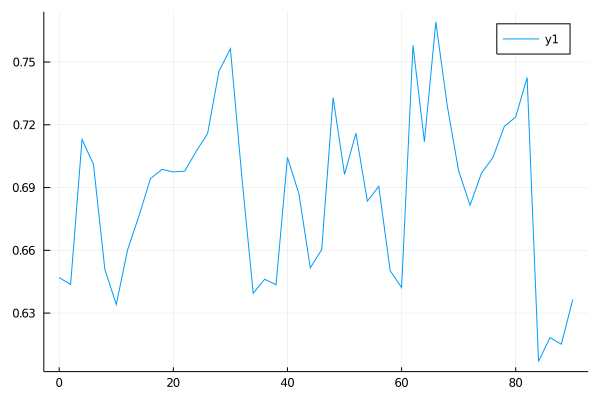

In [199]:
plot(lats,result)
# result

In [186]:
tes = ones(7,7)

7×7 Array{Float64,2}:
 1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0

In [191]:
tes[:,end]

7-element Array{Float64,1}:
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0